In [1]:
%matplotlib inline
import pickle
import xarray as xr
import pandas as pd
import numpy as np
import seaborn
import json

from ion_functions.data.opt_functions_tscor import tscor

Functions for parsing the calibration files and the output from the vendor software (WetView)

In [2]:
def parse_calibration(filename):
    tbins = []
    tcal = None
    nbins = None
    cwlngth = []
    awlngth = []
    ccwo = []
    acwo = []
    tcarray = []
    taarray = []

    with open(filename) as fh:
        for line in fh:
            parts = line.split(';')
            if len(parts) != 2:
                parts = line.split()
                if parts[0] == '"tcal:':
                    tcal = float(parts[1])
                continue
            data, comment = parts

            if comment.startswith(' temperature bins'):
                tbins = data.split()
                tbins = [float(x) for x in tbins]

            elif comment.startswith(' number of temperature bins'):
                nbins = int(data)

            elif comment.startswith(' C and A offset'):
                if nbins is None:
                    print 'Error - failed to read number of temperature bins'
                    return
                parts = data.split()
                cwlngth.append(float(parts[0][1:]))
                awlngth.append(float(parts[1][1:]))
                ccwo.append(float(parts[3]))
                acwo.append(float(parts[4]))
                tcrow = [float(x) for x in parts[5:nbins+5]]
                tarow = [float(x) for x in parts[nbins+5:2*nbins+5]]
                tcarray.append(tcrow)
                taarray.append(tarow)
        
        return {
            'tbins': np.array(tbins),
            'tcal': np.array(tcal),
            'cwlngth': np.array(cwlngth),
            'awlngth': np.array(awlngth),
            'ccwo': np.array(ccwo),
            'acwo': np.array(acwo),
            'tcarray': np.array(tcarray),
            'taarray': np.array(taarray),
        }
    
def parse_wetview_dat(filename):
    start = False
    freqs = []
    values = []
    with open(filename) as fh:
        for line in fh:
            if not start and "acquisition" in line:
                start = True
                continue
            if start:
                if not freqs:
                    freqs = line.split()
                else:
                    values.append([float(x) for x in line.split()[1:len(freqs)+1]])
                    
    return np.array(values)

Functions for calculating optical absorbtion and beam attenuation.

These were tested and verified to produce the same output as the matching functions in ion-functions but without the corresponding adjustment for temperature and salinity, as this adjustment is not made by the vendor software.

In [3]:
def temp_offset(temps, tbins, tarray):
    insertion_point = np.searchsorted(tbins, temps) - 1
    T0 = tbins[insertion_point]
    T1 = tbins[insertion_point+1]
    dT0 = tarray[:, insertion_point]
    dT1 = tarray[:, insertion_point+1]
    return (dT0 + ((temps - T0) / (T1 - T0)) * (dT1 - dT0)).T

def opt_internal_temp(traw):
    # convert counts to volts
    volts = 5. * traw / 65535.

    # calculate the resistance of the thermistor
    res = 10000. * volts / (4.516 - volts)

    # convert resistance to temperature
    a = 0.00093135
    b = 0.000221631
    c = 0.000000125741

    log_res = np.log(res)
    degC = (1. / (a + b * log_res + c * log_res**3)) - 273.15
    return degC

def tempsal_corr(channel, wavelength, tcal, T, PS):
    # apply the temperature and salinity corrections for each wavelength
    # use a list comprehension to read in only those values required into a np array
    np_tscor = np.array([tscor[ii] for ii in wavelength])
    
    T = np.atleast_2d(T)
    PS = np.atleast_2d(PS)
    
    dT = T - tcal
    
    temp_cor = np_tscor[:, 0]
    if channel == 'a':
        sal_cor = np_tscor[:, 2]
    elif channel == 'c':
        sal_cor = np_tscor[:, 1]
    else:
        raise ValueError
        
    return (dT.T * temp_cor) + (PS.T * sal_cor)

def optaa_compute(ref, sig, traw, wl, off, tcal, tbins, tarray, T, PS, channel):
    if len(wl.shape) > 1:
        wl = wl[0]
    if len(off.shape) > 1:
        off = off[0]
    if len(tcal.shape) > 1:
        tcal = tcal[0]
    if len(tbins.shape) > 1:
        tbins = tbins[0]
    if len(tarray.shape) > 2:
        tarray = tarray[0]
    
    raw = off - np.log(1.0 * sig / ref) / 0.25
    offset = temp_offset(opt_internal_temp(traw), tbins, tarray)
    corr = tempsal_corr(channel, wl, tcal, T, PS)
    return  raw - offset - corr

def opt_atten(cref, csig, traw, cwl, coff, tcal, tbins, tc_arr, T, PS):
    return optaa_compute(cref, csig, traw, cwl, coff, tcal, tbins, tc_arr, T, PS, 'c')

def opt_absorb(aref, asig, traw, awl, aoff, tcal, tbins, ta_arr, T, PS):
    return optaa_compute(aref, asig, traw, awl, aoff, tcal, tbins, ta_arr, T, PS, 'a')

Load the data:

* OPTAAD301.dat - wetview processed data
* OPTAAD301.xr  - instrument driver decoded data
* acs134.dev    - calibration file

In [4]:
wetview_data = parse_wetview_dat('OPTAAD301.dat')

wetview_ds = xr.Dataset({'a': (('dim_0', 'dim_1'), wetview_data[:, 83:]),
                         'c': (('dim_0', 'dim_1'), wetview_data[:, :83])})

ds = pickle.load(open('OPTAAD301.xr'))
cal_dict = parse_calibration('acs134.dev')

Calculate beam attentuation and optical absorbtion coefficients.

Temperature and Salinity fixed at 0 to produce the same output as vendor software.

In [5]:
awlngth = cal_dict['awlngth']
cwlngth = cal_dict['cwlngth']
acwo = cal_dict['acwo']
ccwo = cal_dict['ccwo']
tcal = cal_dict['tcal']
tbins = cal_dict['tbins']
taarray = cal_dict['taarray']
tcarray = cal_dict['tcarray']

ds['c_corrected'] = (('dim_0', 'dim_1'),
                     opt_atten(ds.c_reference_counts.values,
                                            ds.c_signal_counts.values,
                                            ds.internal_temp_raw.values,
                                            cwlngth,
                                            ccwo,
                                            tcal,
                                            tbins,
                                            tcarray,
                                            0,
                                            0))
ds['a_corrected'] = (('dim_0', 'dim_1'),
                     opt_absorb(ds.a_reference_counts.values,
                                            ds.a_signal_counts.values,
                                            ds.internal_temp_raw.values,
                                            awlngth,
                                            acwo,
                                            tcal,
                                            tbins,
                                            taarray,
                                            0,
                                            0))

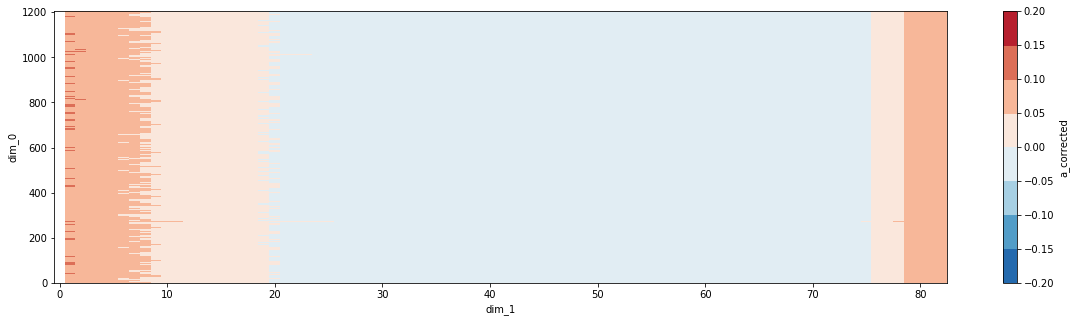

In [6]:
ds.a_corrected.plot(levels = 8, figsize=(20, 5))

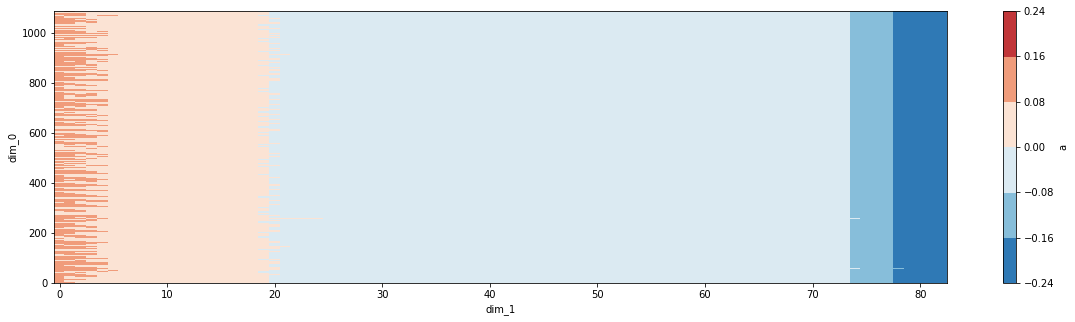

In [7]:
wetview_ds.a.plot(levels=8, figsize=(20, 5))

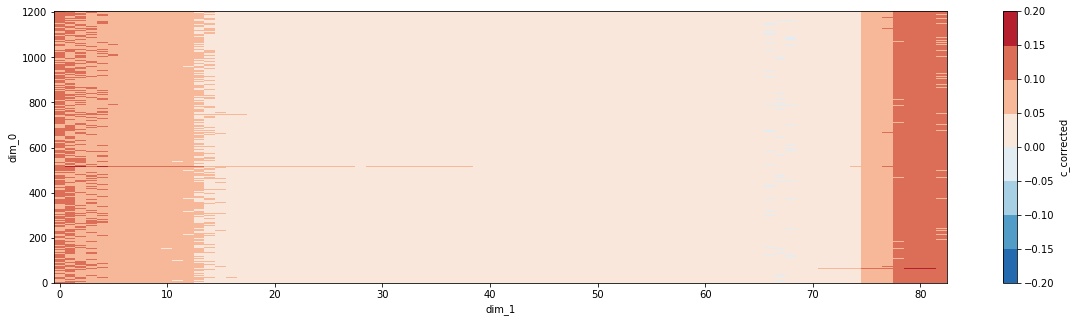

In [8]:
ds.c_corrected.plot(levels=8, figsize=(20, 5))

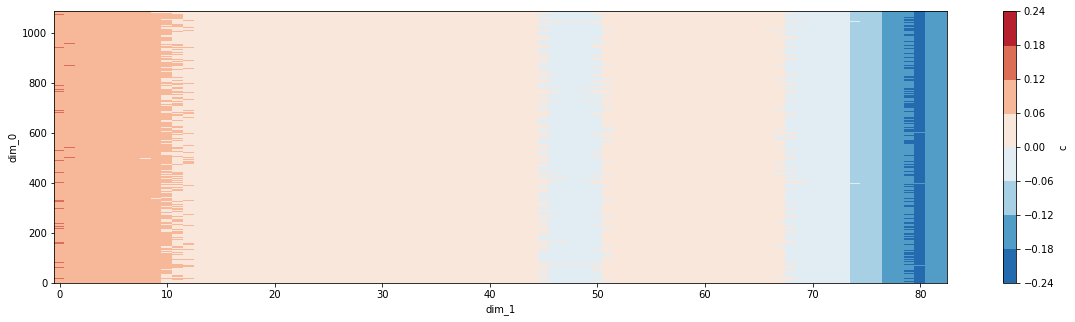

In [9]:
wetview_ds.c.plot(levels=8, figsize=(20, 5))